In [2]:
import zipfile
import os
import random
from PIL import Image, ImageOps, UnidentifiedImageError
import io
import zipfile
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization


In [3]:
# Preprocessing parameters
desired_size = (64, 64)  # Example size, similar to MNIST dataset

# Function to preprocess images: resize and convert to grayscale
def preprocess_image(image):
    image = ImageOps.grayscale(image)  # Convert to grayscale
    image = image.resize(desired_size, Image.Resampling.LANCZOS)  # Resize image using LANCZOS
    return np.array(image)  # Convert to numpy array

def extract_digit_from_dirname(dirname):
    # Assuming the format "Digit"
    return dirname

def extract_and_preprocess_images_from_dir(directory):
    label = extract_digit_from_dirname(os.path.basename(directory))
    images_data = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                image_path = os.path.join(directory, filename)
                image = Image.open(image_path)
                # Preprocess image
                preprocessed_image = preprocess_image(image)
                # Store image data with label
                images_data.append({'image': preprocessed_image, 'label': label})
            except (OSError, UnidentifiedImageError) as e:
                print(f"Cannot identify or read image file {filename} in {directory}: {e}")
    return images_data

base_dir = r'C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals'
digit_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Extract, preprocess, and label images from all directories
all_images_data = []
for digit_dir in digit_dirs:
    print(f"Processing {digit_dir}...")
    images_data = extract_and_preprocess_images_from_dir(digit_dir)
    all_images_data.extend(images_data)
    print(f"Processed {len(images_data)} images from {digit_dir}.")


Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Eight...
Processed 237 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Eight.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Five...
Processed 243 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Five.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Four...
Processed 249 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Four.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduati

In [4]:
if all_images_data:
    first_image_data = all_images_data[1500]
    img = Image.fromarray(first_image_data['image'])
    img.show()
    print(f"First image label: {first_image_data['label']}")

First image label: Six


Split the dataset

In [5]:

# Mapping from string labels to integers (you should complete this mapping)
label_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5,
    'Six': 6,
    'Seven': 7,
    'Eight': 8,
    'Nine': 9
}

def preprocess_dataset(all_images_data):
    # Separate images and labels
    images = np.array([entry['image'] for entry in all_images_data])
    labels = np.array([label_mapping[entry['label']] for entry in all_images_data])
    
    # Normalize the images
    images = images.astype(np.float32) / 255.0
    
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=10)  # Assuming 10 classes for Arabic numerals
    
    # Reshape the images to add the channel dimension (1 channel for grayscale)
    images = images.reshape(-1, 64, 64, 1)
    
    return images, labels


def split_dataset(images, labels, train_frac=0.7, valid_frac=0.15):
    # Calculate sizes for each set
    total_size = len(images)
    train_size = int(train_frac * total_size)
    valid_size = int(valid_frac * total_size)
    test_size = total_size - train_size - valid_size

    # Shuffle the data
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    # Split the data
    train_images, train_labels = images[:train_size], labels[:train_size]
    valid_images, valid_labels = images[train_size:train_size+valid_size], labels[train_size:train_size+valid_size]
    test_images, test_labels = images[train_size+valid_size:], labels[train_size+valid_size:]

    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

# Preprocess the entire dataset
images, labels = preprocess_dataset(all_images_data)

# Split the dataset
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)

# Output the sizes of the splits
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(valid_images)}")
print(f"Testing set size: {len(test_images)}")


Training set size: 1723
Validation set size: 369
Testing set size: 370


In [6]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model
model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                        

In [7]:
# Configure early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model
history = model.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[early_stopping_callback]           # Early stopping callback
)

Epoch 1/50
54/54 [==============================] - 21s 137ms/step - loss: 2.3218 - accuracy: 0.0917 - val_loss: 2.3034 - val_accuracy: 0.0949
Epoch 2/50
54/54 [==============================] - 4s 78ms/step - loss: 2.3028 - accuracy: 0.1045 - val_loss: 2.3041 - val_accuracy: 0.0949
Epoch 3/50
54/54 [==============================] - 4s 75ms/step - loss: 2.3018 - accuracy: 0.1103 - val_loss: 2.3056 - val_accuracy: 0.0949
Epoch 4/50
54/54 [==============================] - 4s 76ms/step - loss: 2.3020 - accuracy: 0.1004 - val_loss: 2.3054 - val_accuracy: 0.0949
Epoch 5/50
54/54 [==============================] - 4s 80ms/step - loss: 2.2895 - accuracy: 0.1265 - val_loss: 2.1940 - val_accuracy: 0.2005
Epoch 6/50
54/54 [==============================] - 4s 78ms/step - loss: 2.1228 - accuracy: 0.2188 - val_loss: 1.9720 - val_accuracy: 0.3496
Epoch 7/50
54/54 [==============================] - 4s 77ms/step - loss: 1.8511 - accuracy: 0.3656 - val_loss: 1.6434 - val_accuracy: 0.4444
Epoch 8/50


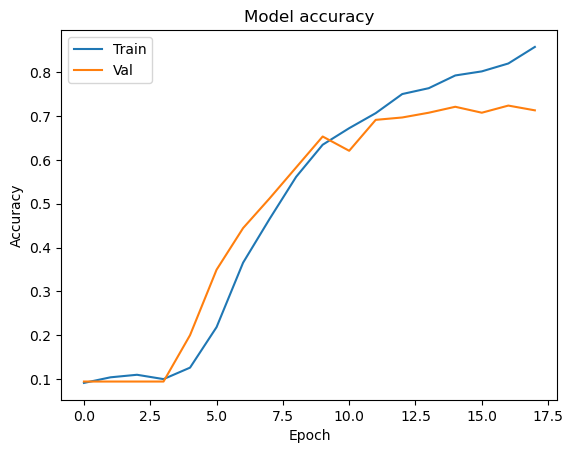

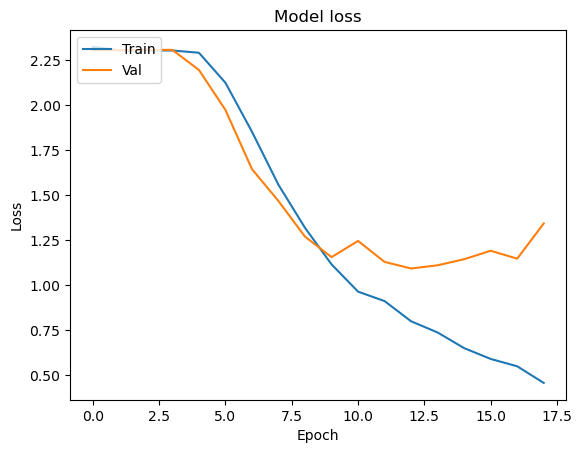

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 - 1s - loss: 1.1259 - accuracy: 0.6784 - 801ms/epoch - 67ms/step
Test Loss: 1.1259249448776245
Test Accuracy: 0.6783784031867981


12/12 [==============================] - 1s 20ms/step


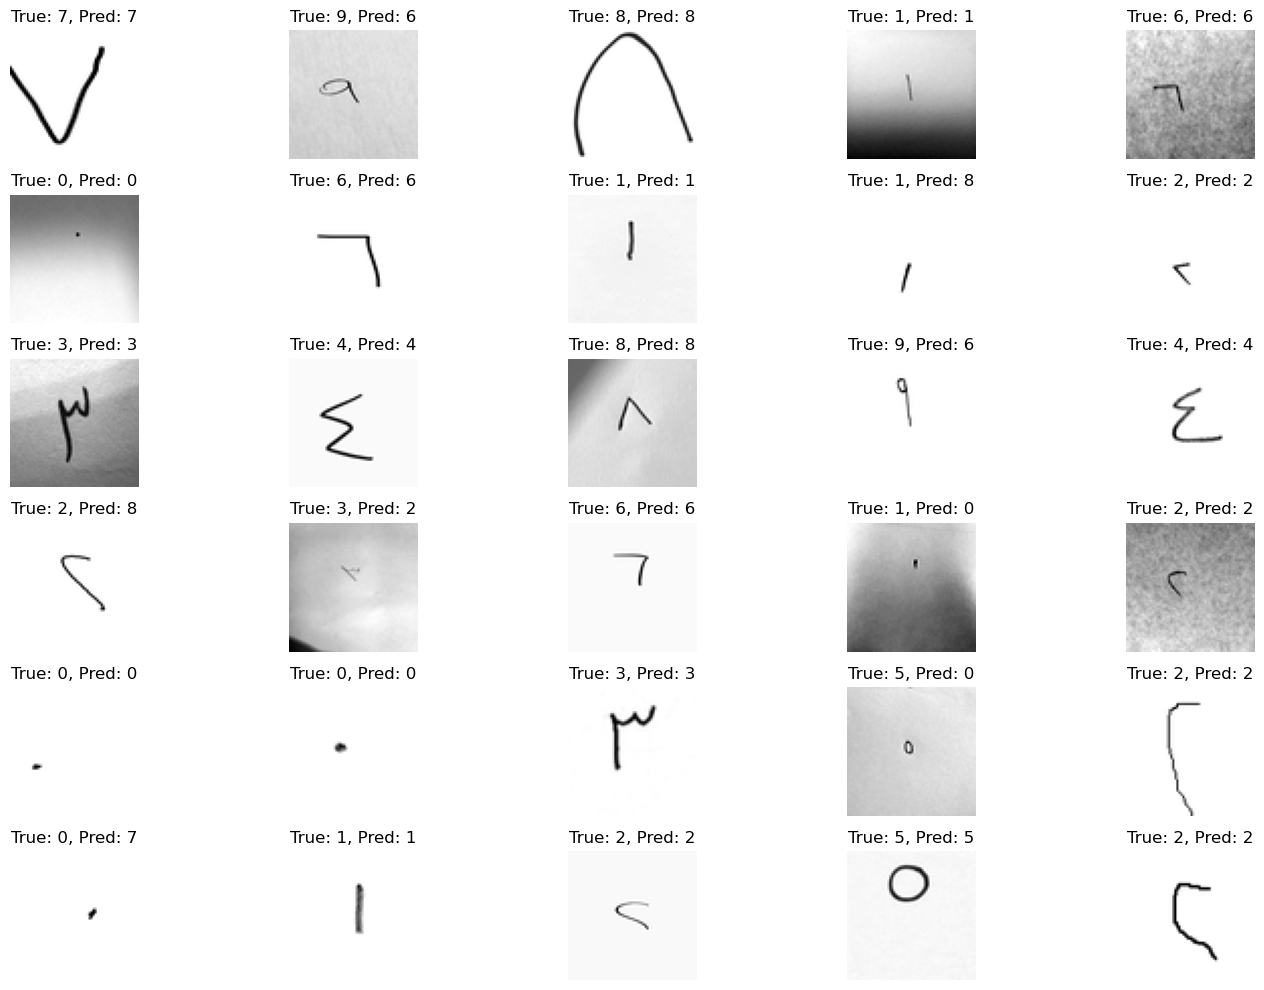

In [10]:
# Making predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model2():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(64, 64, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model
model3 = build_model2()
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                      

In [12]:
# Configure early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)


checkpoint_path = "model3_weights_best.weights.h5"  # Changed the extension as per the error message
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',  # or 'val_loss' if you prefer to monitor the loss
    mode='max',  # 'min' if you monitor the loss
    save_best_only=True,
    verbose=1,
)
# Fit the model
history2 = model3.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[model_checkpoint_callback , early_stopping_callback]           # Early stopping callback
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 2.3142 - accuracy: 0.0992
Epoch 1: val_accuracy improved from -inf to 0.10840, saving model to model3_weights_best.weights.h5
54/54 [==============================] - 9s 105ms/step - loss: 2.3142 - accuracy: 0.0992 - val_loss: 2.3031 - val_accuracy: 0.1084
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 2.2562 - accuracy: 0.1613
Epoch 2: val_accuracy improved from 0.10840 to 0.25203, saving model to model3_weights_best.weights.h5
54/54 [==============================] - 4s 79ms/step - loss: 2.2562 - accuracy: 0.1613 - val_loss: 2.1098 - val_accuracy: 0.2520
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 2.0012 - accuracy: 0.2861
Epoch 3: val_accuracy improved from 0.25203 to 0.37940, saving model to model3_weights_best.weights.h5
54/54 [==============================] - 4s 79ms/step - loss: 2.0012 - accuracy: 0.2861 - val_loss: 1.8587 - val_accuracy: 0.3794
Epoch 4/50
54/54 [===

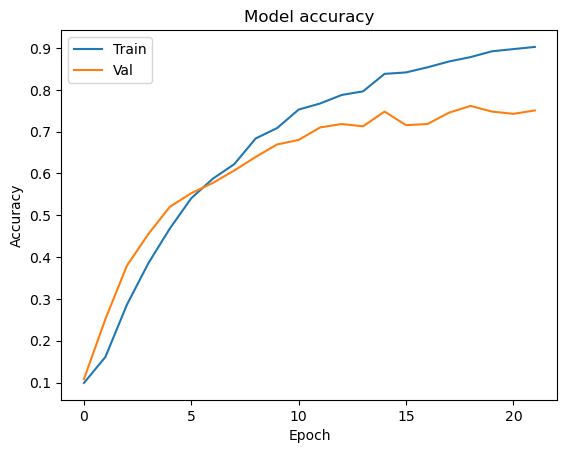

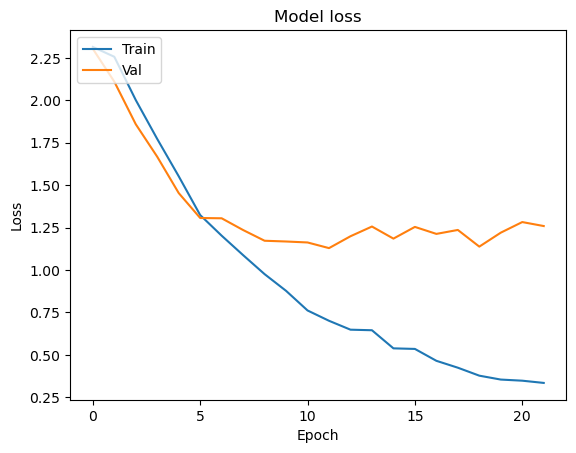

In [13]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [14]:
model3.load_weights("model3_weights_best.weights.h5")

test_loss, test_accuracy = model3.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


12/12 - 0s - loss: 1.1016 - accuracy: 0.7108 - 307ms/epoch - 26ms/step
Test Loss: 1.101639986038208
Test Accuracy: 0.7108108401298523


12/12 [==============================] - 1s 18ms/step


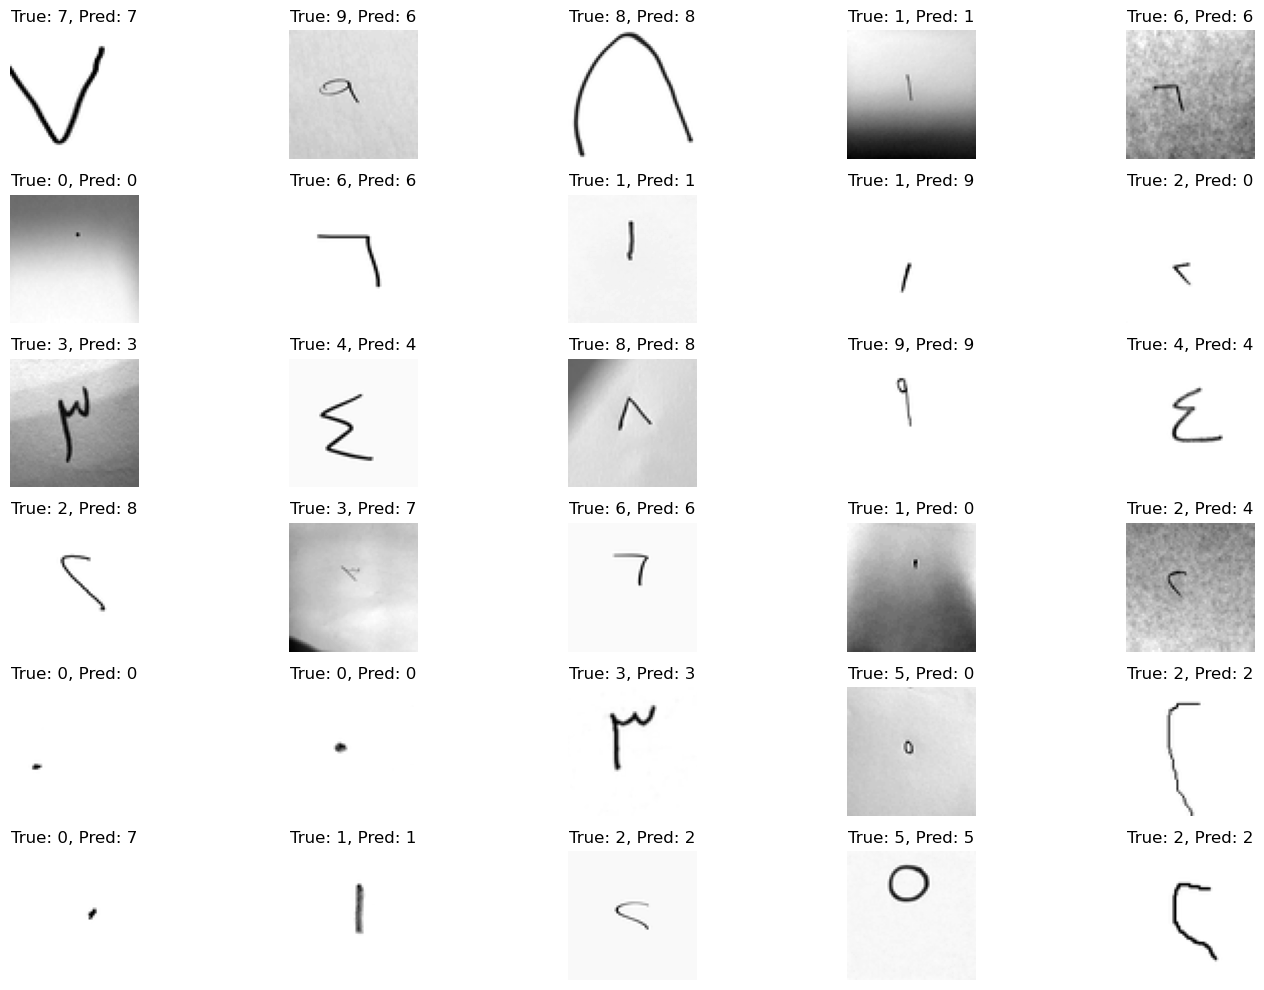

In [15]:
# Making predictions on the test set
predictions = model3.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)

In [16]:
from PIL import ImageFilter


In [18]:
# Preprocessing parameters
desired_size = (32, 32)  # Example size, similar to MNIST dataset

# Function to preprocess images: resize and convert to grayscale
def preprocess_image(image):
    image = ImageOps.grayscale(image)  # Convert to grayscale
    image = image.filter(ImageFilter.GaussianBlur(1))  # Apply Gaussian Blur for noise reduction
    image = image.resize(desired_size, Image.Resampling.LANCZOS)  # Resize image using LANCZOS
    return np.array(image)  # Convert to numpy array

# Function to extract the digit label from the directory name
def extract_digit_from_dirname(dirname):
    # Assuming the format "Digit"
    return dirname

# Function to extract and preprocess images from a directory
def extract_and_preprocess_images_from_dir(directory):
    label = extract_digit_from_dirname(os.path.basename(directory))
    images_data = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            try:
                image_path = os.path.join(directory, filename)
                image = Image.open(image_path)
                # Preprocess image
                preprocessed_image = preprocess_image(image)
                # Store image data with label
                images_data.append({'image': preprocessed_image, 'label': label})
            except (OSError, UnidentifiedImageError) as e:
                print(f"Cannot identify or read image file {filename} in {directory}: {e}")
    return images_data

# Define the directory where the images are located
base_dir = r'C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals'
digit_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]


# Extract, preprocess, and label images from all directories
all_images_data = []
for digit_dir in digit_dirs:
    print(f"Processing {digit_dir}...")
    images_data = extract_and_preprocess_images_from_dir(digit_dir)
    all_images_data.extend(images_data)
    print(f"Processed {len(images_data)} images from {digit_dir}.")


Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Eight...
Processed 237 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Eight.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Five...
Processed 243 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Five.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Four...
Processed 249 images from C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduation Project\numerals\Four.
Processing C:\Users\ryabu\OneDrive - Egypt Japan University Of Science and Technology (E-JUST)\Documents\Graduati

In [19]:
if all_images_data:
    first_image_data = all_images_data[1500]
    img = Image.fromarray(first_image_data['image'])
    img.show()
    print(f"First image label: {first_image_data['label']}")

First image label: Six


In [20]:

# Mapping from string labels to integers (you should complete this mapping)
label_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5,
    'Six': 6,
    'Seven': 7,
    'Eight': 8,
    'Nine': 9
}

def preprocess_dataset(all_images_data):
    # Separate images and labels
    images = np.array([entry['image'] for entry in all_images_data])
    labels = np.array([label_mapping[entry['label']] for entry in all_images_data])
    
    # Normalize the images
    images = images.astype(np.float32) / 255.0
    
    # Convert labels to one-hot encoding
    labels = to_categorical(labels, num_classes=10)  # Assuming 10 classes for Arabic numerals
    
    # Reshape the images to add the channel dimension (1 channel for grayscale)
    images = images.reshape(-1, 32, 32, 1)
    
    return images, labels


def split_dataset(images, labels, train_frac=0.7, valid_frac=0.15):
    # Calculate sizes for each set
    total_size = len(images)
    train_size = int(train_frac * total_size)
    valid_size = int(valid_frac * total_size)
    test_size = total_size - train_size - valid_size

    # Shuffle the data
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    # Split the data
    train_images, train_labels = images[:train_size], labels[:train_size]
    valid_images, valid_labels = images[train_size:train_size+valid_size], labels[train_size:train_size+valid_size]
    test_images, test_labels = images[train_size+valid_size:], labels[train_size+valid_size:]

    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

# Preprocess the entire dataset
images, labels = preprocess_dataset(all_images_data)

# Split the dataset
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = split_dataset(images, labels)

# Output the sizes of the splits
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(valid_images)}")
print(f"Testing set size: {len(test_images)}")


Training set size: 1723
Validation set size: 369
Testing set size: 370


In [21]:
from keras.regularizers import l2

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(32, 32, 1),
                     kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))  # Assuming 10 classes for digits 0-9
    return model


# Compile the model
model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # To output the progress
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity
)


checkpoint_path = "model666_weights_best.weights.h5"  # Changed the extension as per the error message
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',  # or 'val_loss' if you prefer to monitor the loss
    mode='max',  # 'min' if you monitor the loss
    save_best_only=True,
    verbose=1,
)
# Fit the model
history2 = model.fit(
    train_images, train_labels,
    epochs=50,                    # Maximum number of epochs to train for
    batch_size=32,                # The size of the batches to use during training
    validation_data=(valid_images, valid_labels), # Validation data to monitor
    callbacks=[model_checkpoint_callback]      
    )    # Early stopping callback

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 3.7921 - accuracy: 0.1341
Epoch 1: val_accuracy improved from -inf to 0.08672, saving model to model666_weights_best.weights.h5
54/54 [==============================] - 9s 72ms/step - loss: 3.7921 - accuracy: 0.1341 - val_loss: 3.0104 - val_accuracy: 0.0867
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 3.2498 - accuracy: 0.2014
Epoch 2: val_accuracy improved from 0.08672 to 0.09756, saving model to model666_weights_best.weights.h5
54/54 [==============================] - 2s 38ms/step - loss: 3.2498 - accuracy: 0.2014 - val_loss: 3.1719 - val_accuracy: 0.0976
Epoch 3/50
53/54 [============================>.] - ETA: 0s - loss: 2.9678 - accuracy: 0.2759
Epoch 3: val_accuracy did not improve from 0.09756
54/54 [==============================] - 2s 33ms/step - loss: 2.9702 - accuracy: 0.2757 - val_loss: 3.4134 - val_accuracy: 0.0976
Epoch 4/50
53/54 [============================>.] - ETA: 0s - loss: 2.

In [23]:
model.load_weights("model666_weights_best.weights.h5")

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 - 0s - loss: 1.1532 - accuracy: 0.8297 - 475ms/epoch - 40ms/step
Test Loss: 1.1531808376312256
Test Accuracy: 0.8297297358512878


12/12 [==============================] - 1s 13ms/step


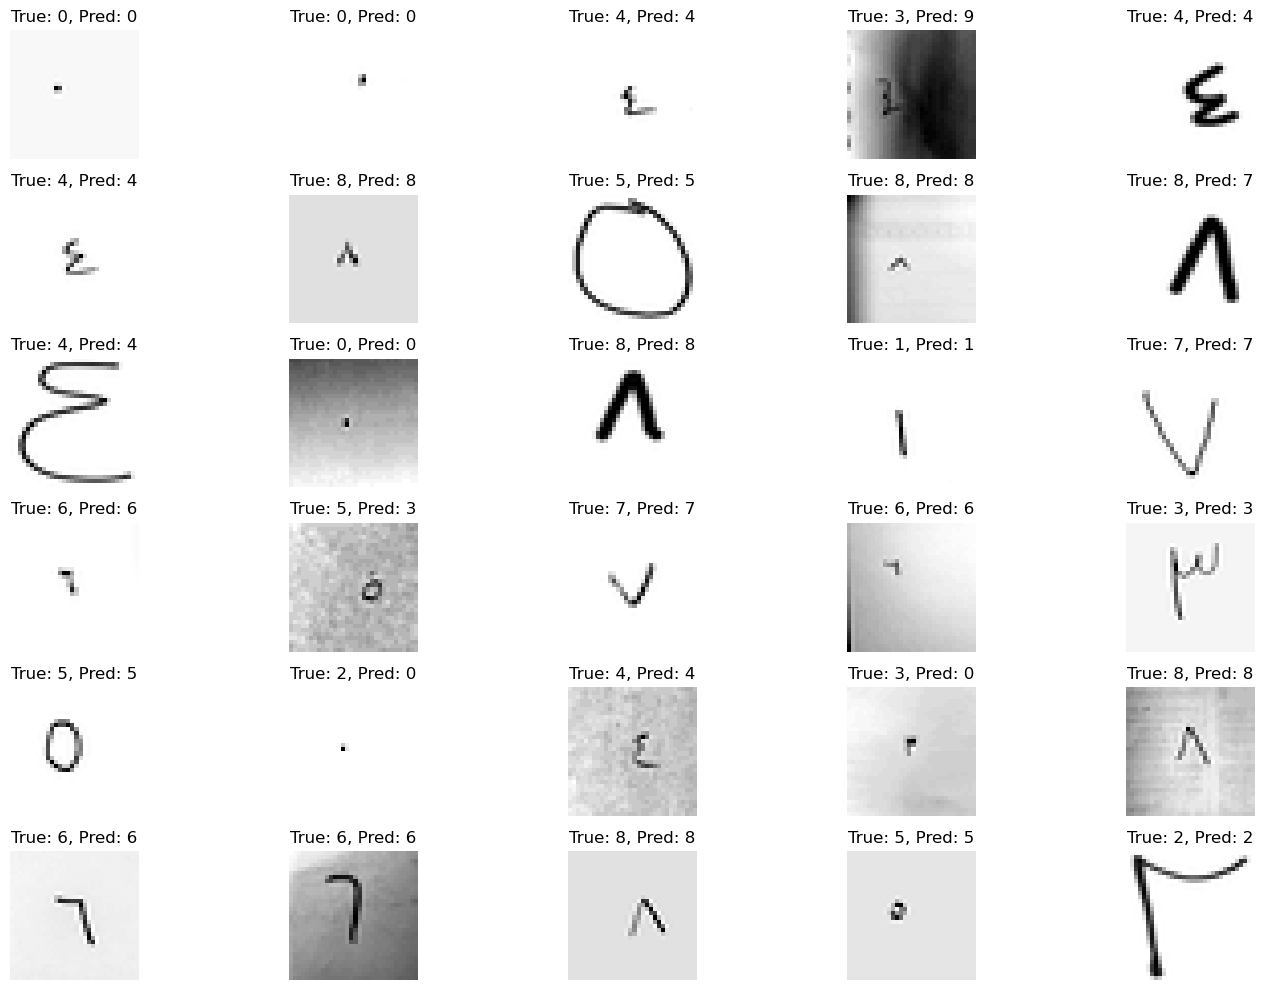

In [24]:
# Making predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 15 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,LearningRateScheduler
from keras.optimizers import Adam


In [26]:
from keras.regularizers import l2

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(32, 32, 1),
                     kernel_regularizer=l2(0.001)))  # L2 regularization
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))  # Assuming 10 classes for digits 0-9
    return model


# Compile the model
model2 = build_model()
adam = Adam(learning_rate=0.0001)
model2.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [27]:

# Callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model2_best_weights.weights.h5",  # Adjusted the file extension
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.001,
    verbose=1)

# Fit the custom model
history_custom_model = model2.fit(
    train_images, train_labels,
    epochs=100, 
    validation_data=(valid_images, valid_labels),
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])

Epoch 1/100
53/54 [============================>.] - ETA: 0s - loss: 4.1397 - accuracy: 0.1203
Epoch 1: val_accuracy improved from -inf to 0.08672, saving model to model2_best_weights.weights.h5
54/54 [==============================] - 9s 60ms/step - loss: 4.1316 - accuracy: 0.1219 - val_loss: 3.0724 - val_accuracy: 0.0867 - lr: 1.0000e-04
Epoch 2/100
53/54 [============================>.] - ETA: 0s - loss: 3.8816 - accuracy: 0.1297
Epoch 2: val_accuracy improved from 0.08672 to 0.13550, saving model to model2_best_weights.weights.h5
54/54 [==============================] - 2s 38ms/step - loss: 3.8793 - accuracy: 0.1306 - val_loss: 3.2619 - val_accuracy: 0.1355 - lr: 1.0000e-04
Epoch 3/100
53/54 [============================>.] - ETA: 0s - loss: 3.6758 - accuracy: 0.1533
Epoch 3: val_accuracy did not improve from 0.13550
54/54 [==============================] - 2s 35ms/step - loss: 3.6668 - accuracy: 0.1561 - val_loss: 3.4306 - val_accuracy: 0.0921 - lr: 1.0000e-04
Epoch 4/100
54/54 [=

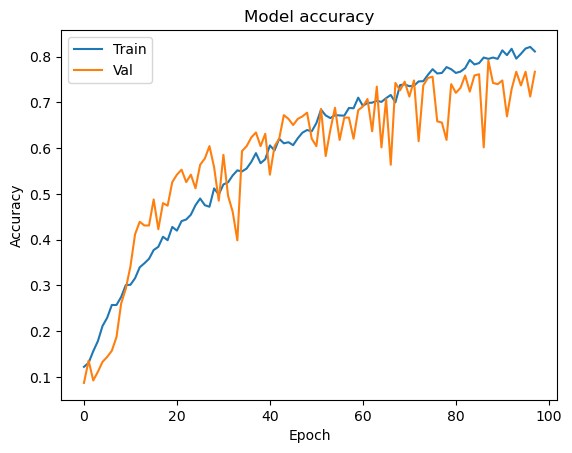

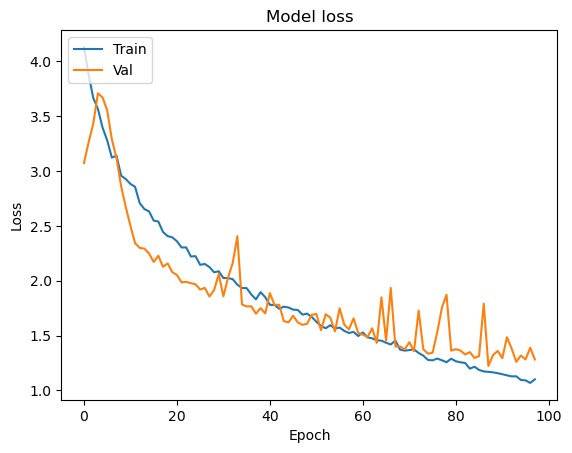

In [28]:
# Plot training & validation accuracy values
plt.plot(history_custom_model.history['accuracy'])
plt.plot(history_custom_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [29]:
model2.load_weights("model2_best_weights.weights.h5")

test_loss, test_accuracy = model2.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 - 0s - loss: 1.2438 - accuracy: 0.7838 - 163ms/epoch - 14ms/step
Test Loss: 1.2437689304351807
Test Accuracy: 0.7837837934494019


rewan

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

# Fit the model using the augmented data generator
history_custom_model = model2.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=100,
    validation_data=(valid_images, valid_labels),
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])


Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.7051 - accuracy: 0.6280
Epoch 1: val_accuracy did not improve from 0.79133
54/54 [==============================] - 2s 27ms/step - loss: 1.7051 - accuracy: 0.6280 - val_loss: 1.5787 - val_accuracy: 0.6694 - lr: 1.0000e-04
Epoch 2/100
54/54 [==============================] - ETA: 0s - loss: 1.6753 - accuracy: 0.6344
Epoch 2: val_accuracy did not improve from 0.79133
54/54 [==============================] - 2s 27ms/step - loss: 1.6753 - accuracy: 0.6344 - val_loss: 1.5698 - val_accuracy: 0.6287 - lr: 1.0000e-04
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.7099 - accuracy: 0.6158
Epoch 3: val_accuracy did not improve from 0.79133
54/54 [==============================] - 1s 27ms/step - loss: 1.7099 - accuracy: 0.6158 - val_loss: 1.2824 - val_accuracy: 0.7588 - lr: 1.0000e-04
Epoch 4/100
54/54 [==============================] - ETA: 0s - loss: 1.6799 - accuracy: 0.6233
Epoch 4: val_accuracy did 

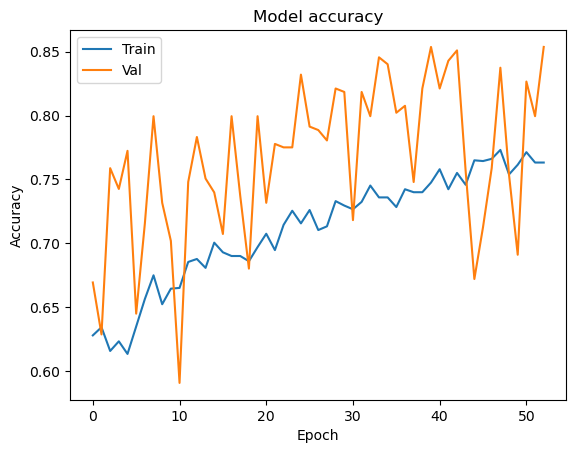

In [37]:
# Plot training & validation accuracy values
plt.plot(history_custom_model.history['accuracy'])
plt.plot(history_custom_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


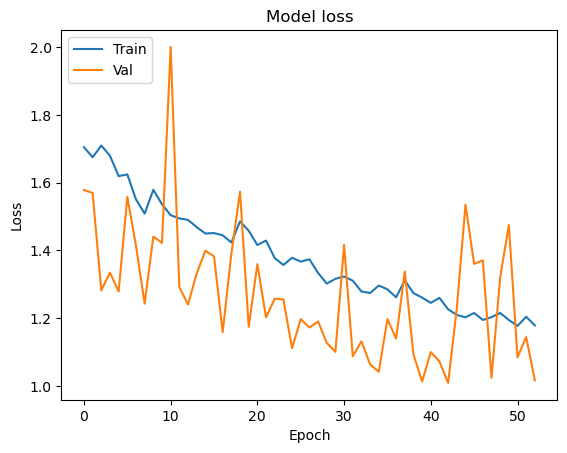

In [38]:
# Plot training & validation loss values
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [47]:
model2.load_weights("model2_best_weights.weights.h5")

test_loss, test_accuracy = model2.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 - 0s - loss: 1.0300 - accuracy: 0.8351 - 250ms/epoch - 21ms/step
Test Loss: 1.029982566833496
Test Accuracy: 0.8351351618766785


12/12 [==============================] - 0s 11ms/step


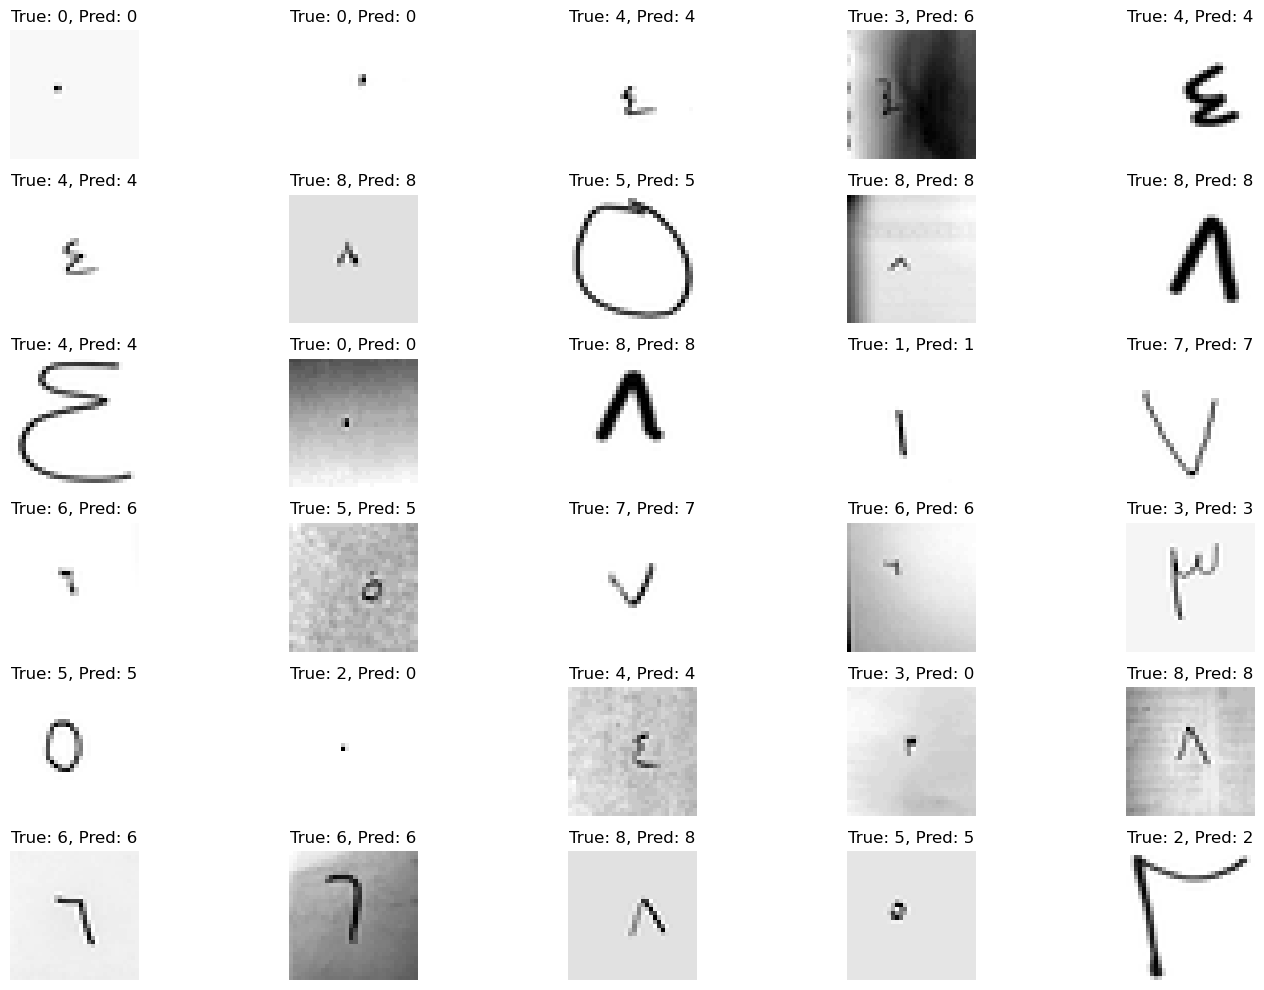

In [41]:
# Making predictions on the test set
predictions = model2.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 30 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)

In [44]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(32, 32, 1),
                     kernel_regularizer=l2(0.0005)))  # Adjusted L2 regularization
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))  # Adjusted dropout rate

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # Adjusted dropout rate

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Adjusted dropout rate
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0005)))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model with Adam optimizer
model4 = build_model()
adam = Adam(learning_rate=0.0001)
model4.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


# Callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model4_best_weights.weights.h5",  # Adjusted the file extension
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.001,
    verbose=1)

# Fit the model using the augmented data generator
history_custom_model = model4.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=100,
    validation_data=(valid_images, valid_labels),
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr])


Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 1.6318 - accuracy: 0.5676
Epoch 1: val_accuracy improved from -inf to 0.63415, saving model to model4_best_weights.weights.h5
54/54 [==============================] - 2s 38ms/step - loss: 1.6318 - accuracy: 0.5676 - val_loss: 1.4732 - val_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 2/100
53/54 [============================>.] - ETA: 0s - loss: 1.5882 - accuracy: 0.5742
Epoch 2: val_accuracy did not improve from 0.63415
54/54 [==============================] - 2s 33ms/step - loss: 1.5866 - accuracy: 0.5752 - val_loss: 2.2547 - val_accuracy: 0.4715 - lr: 1.0000e-04
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 1.5625 - accuracy: 0.5827
Epoch 3: val_accuracy improved from 0.63415 to 0.64499, saving model to model4_best_weights.weights.h5
54/54 [==============================] - 2s 37ms/step - loss: 1.5625 - accuracy: 0.5827 - val_loss: 1.4075 - val_accuracy: 0.6450 - lr: 1.0000e-04
Epoch 4/100
54/54 [=

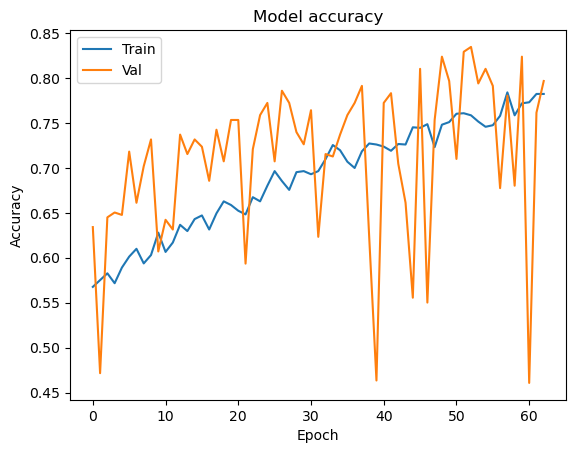

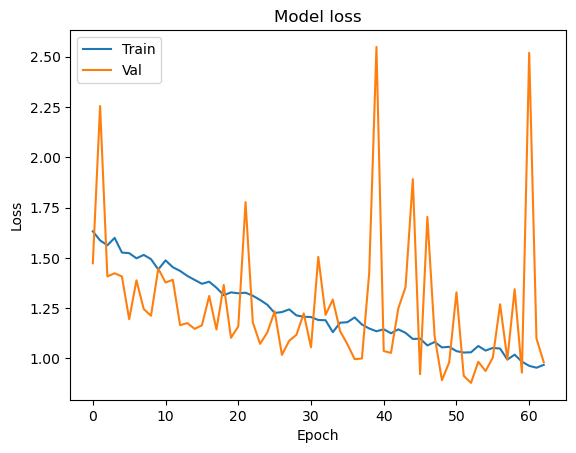

12/12 - 0s - loss: 0.8747 - accuracy: 0.8135 - 248ms/epoch - 21ms/step
Test Loss: 0.8746798038482666
Test Accuracy: 0.8135135173797607


In [49]:

# Plot training & validation accuracy values
plt.plot(history_custom_model.history['accuracy'])
plt.plot(history_custom_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model2.load_weights("model4_best_weights.weights.h5")

test_loss, test_accuracy = model4.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

BEST MODEL

In [54]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(32, 32, 1), kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.0005)))  # Assuming 10 classes for digits 0-9
    return model

# Compile the model with Adam optimizer
model5 = build_model()
adam = Adam(learning_rate=0.0001)
model5.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False)


In [58]:
# Callbacks
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath="model5_best_weights.weights.h5",  # Adjusted the file extension
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=0.00001,
    verbose=1)

# Fit the model using the augmented data generator
history_custom_model = model5.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=100,
    validation_data=(valid_images, valid_labels),
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr, lr_scheduler])


Epoch 1/100
54/54 [==============================] - ETA: 0s - loss: 2.8657 - accuracy: 0.2699
Epoch 1: val_accuracy improved from -inf to 0.20867, saving model to model5_best_weights.weights.h5
54/54 [==============================] - 2s 30ms/step - loss: 2.8657 - accuracy: 0.2699 - val_loss: 2.8912 - val_accuracy: 0.2087 - lr: 0.0010
Epoch 2/100
53/54 [============================>.] - ETA: 0s - loss: 2.7725 - accuracy: 0.2921
Epoch 2: val_accuracy did not improve from 0.20867
54/54 [==============================] - 2s 38ms/step - loss: 2.7671 - accuracy: 0.2931 - val_loss: 2.8300 - val_accuracy: 0.2005 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - ETA: 0s - loss: 2.6973 - accuracy: 0.3180
Epoch 3: val_accuracy did not improve from 0.20867
54/54 [==============================] - 2s 33ms/step - loss: 2.6973 - accuracy: 0.3180 - val_loss: 3.0534 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/100
53/54 [============================>.] - ETA: 0s - loss: 2.5040 - accura

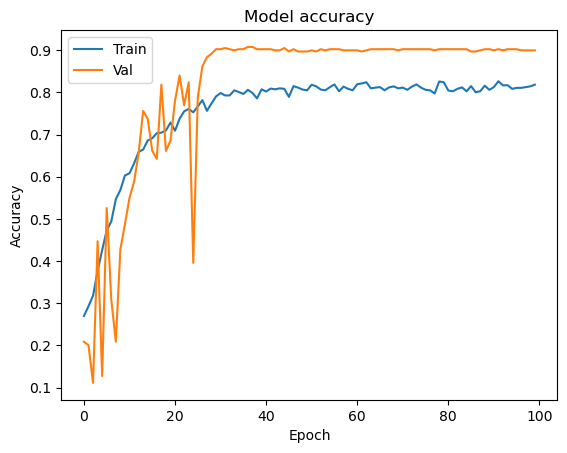

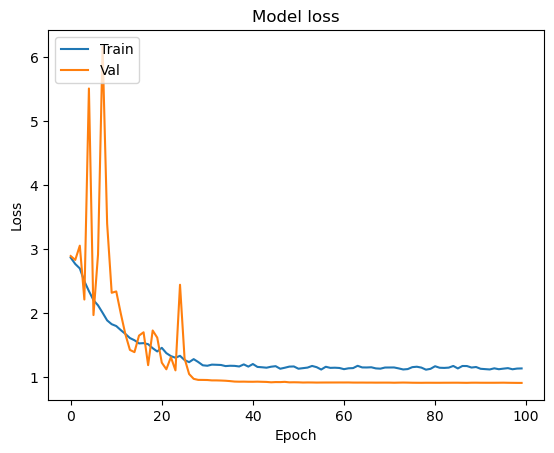

12/12 - 0s - loss: 0.9174 - accuracy: 0.9000 - 417ms/epoch - 35ms/step
Test Loss: 0.9174213409423828
Test Accuracy: 0.8999999761581421


In [61]:

# Plot training & validation accuracy values
plt.plot(history_custom_model.history['accuracy'])
plt.plot(history_custom_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_custom_model.history['loss'])
plt.plot(history_custom_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model5.load_weights("model5_best_weights.weights.h5")

test_loss, test_accuracy = model5.evaluate(test_images, test_labels, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 1s 24ms/step


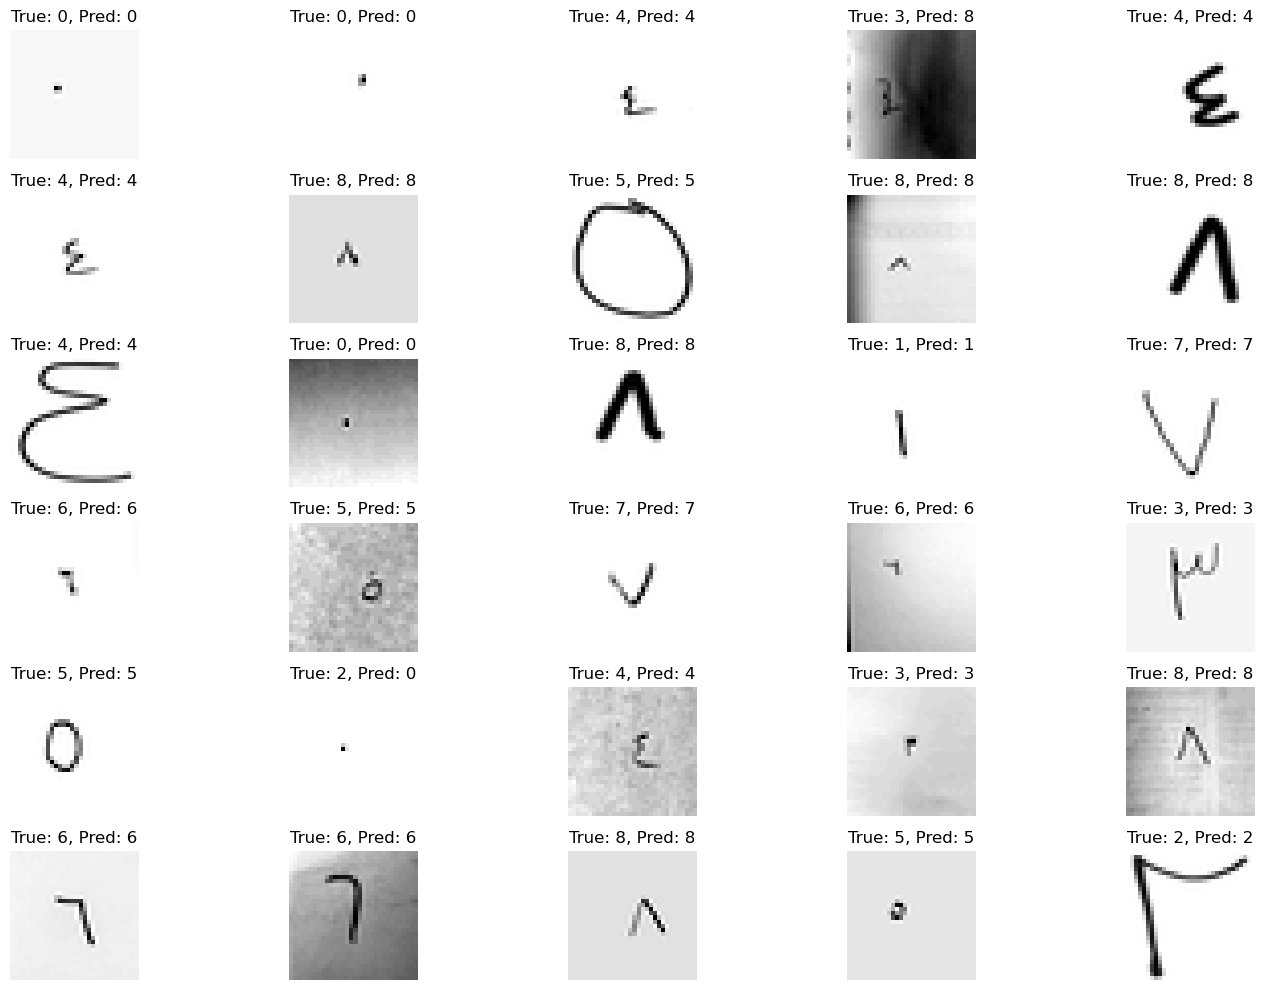

In [62]:
# Making predictions on the test set
predictions = model5.predict(test_images)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Show some of the predictions
def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(30):  # Let's visualize the first 30 images
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
plot_images(test_images, true_classes, predicted_classes)